## Introduction

This notebook parses an output produced by the DENVIS web-service and compares the outputs with the results from the denvis paper.

It assumes that the denvis inference results have already been downloaded using the `download_extract_data.sh` script

Additionally, before making a request to the webservice the `drop_sdf_duplicates.py` script should be run on the sdf file containing the ligand library to be screened.

### Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Configuration

In [2]:
model_selection = 'refined' # 'refined' or 'general'

OUTPUT_TYPES = {
    'refined' : ['Kd', 'Ki'],
    'general' : ['Kd', 'Ki', 'IC50']
}

denvis_data_path = '../data/outputs/denvis_outputs' 

target_id = 'aa2ar'
output_type = OUTPUT_TYPES[model_selection]

### Specify App output path

In [3]:
output_path = "../aa2ar_denvis_webservice.json" # change it to the path of the webservice output

### Parse Webservice Output

In [4]:
raw_output_df = pd.read_json(output_path)

In [5]:
# keep = 'last' is important because that is how we dealt with duplicate ligands in our processing of DUD-E data
# some ligands are represented more than once in the DUD-E sdf files
output_df = raw_output_df.drop_duplicates(subset=['modality','v_num','ligand_id'], keep='last').reset_index(drop=True)

We store the ligand ids to query the denvis inference results

In [6]:
ligand_ids = output_df.ligand_id.unique()

### Load DENVIS results

In [7]:
if model_selection == "refined":
    denvis_atom = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_refined_atom.parquet') )
    denvis_surface = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_refined_surface.parquet') )
elif model_seltcion == "general": 
    denvis_atom = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_general_atom.parquet') )
    denvis_surface = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_general_surface.parquet') )

### Compare differences

Results should look the same apart from tiny differences due to rounding errors etc.

In [8]:
denvis_atom[denvis_atom['ligand_id'].isin(ligand_ids) & (denvis_atom['target_id'] == target_id)].sort_values(by=['ligand_id', 'version'])

,target_id,ligand_id,version,ckpt,y_true,y_score_Kd,y_score_Ki,y_score_IC50
162614,aa2ar,CHEMBL100382,0,0,1.0,2.725062,-2.583702,0.007847
1578481,aa2ar,CHEMBL100382,1,0,1.0,6.586952,-2.676831,0.032344
2994348,aa2ar,CHEMBL100382,2,0,1.0,4.622222,-1.560669,0.010561
4410215,aa2ar,CHEMBL100382,3,0,1.0,3.490108,-4.556562,-0.006366
5826082,aa2ar,CHEMBL100382,4,0,1.0,2.344347,-2.827861,-0.116257
...,...,...,...,...,...,...,...,...
162669,aa2ar,CHEMBL95101,0,0,1.0,1.748837,0.855794,-0.128059
1578536,aa2ar,CHEMBL95101,1,0,1.0,1.122028,-1.689827,-0.078788
2994403,aa2ar,CHEMBL95101,2,0,1.0,5.853607,1.411649,0.055679
4410270,aa2ar,CHEMBL95101,3,0,1.0,1.779458,-0.033722,0.011944


In [9]:
output_df.query('modality == "atom"').sort_values(by=['ligand_id', 'v_num']).reset_index()

,index,Kd,Ki,modality,v_num,ligand_id
0,33,2.725063,-2.583696,atom,version_0,CHEMBL100382
1,133,6.586952,-2.676833,atom,version_1,CHEMBL100382
2,233,4.622223,-1.560671,atom,version_2,CHEMBL100382
3,333,3.490108,-4.556561,atom,version_3,CHEMBL100382
4,433,2.344348,-2.827861,atom,version_4,CHEMBL100382
...,...,...,...,...,...,...
495,88,1.748837,0.855794,atom,version_0,CHEMBL95101
496,188,1.122028,-1.689827,atom,version_1,CHEMBL95101
497,288,5.853604,1.411650,atom,version_2,CHEMBL95101
498,388,1.779457,-0.033722,atom,version_3,CHEMBL95101


Indeed if we take the pairwise differences between the inference results provided in the repo and the output of the we should get differences in the order of $10^{-6}$

Text(0, 0.5, 'Count')

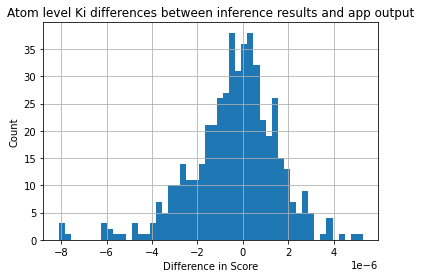

In [10]:
ki_denvis = denvis_atom[(denvis_atom['ligand_id'].isin(ligand_ids)) & (denvis_atom['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
ki_webservice = output_df.query('modality == "atom"').sort_values(by=['ligand_id', 'v_num']).reset_index()["Ki"]
(ki_denvis - ki_webservice).hist(bins=50)
plt.title('Atom level Ki differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

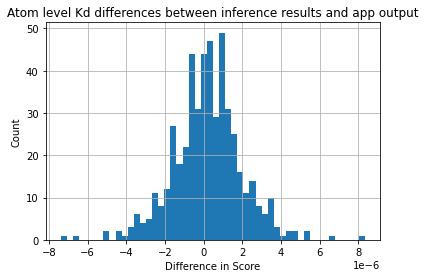

In [11]:
kd_denvis = denvis_atom[(denvis_atom['ligand_id'].isin(ligand_ids)) & (denvis_atom['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Kd"]
kd_webservice = output_df.query('modality == "atom"').sort_values(by=['ligand_id', 'v_num']).reset_index()["Kd"]
(kd_denvis - kd_webservice).hist(bins = 50)
plt.title('Atom level Kd differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

In [12]:
df = (denvis_atom[denvis_atom['ligand_id'].isin(ligand_ids)].sort_values(by=['ligand_id', 'version']).groupby('ligand_id').count()['target_id'] > 5).reset_index()

Text(0, 0.5, 'Count')

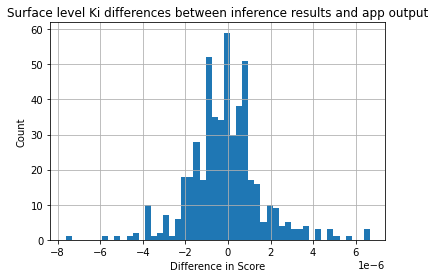

In [13]:
ki_denvis = denvis_surface[(denvis_surface['ligand_id'].isin(ligand_ids)) & (denvis_surface['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
ki_webservice = output_df.query('modality == "surface"').sort_values(by=['ligand_id', 'v_num']).reset_index()["Ki"]
(ki_denvis - ki_webservice).hist(bins=50)
plt.title('Surface level Ki differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

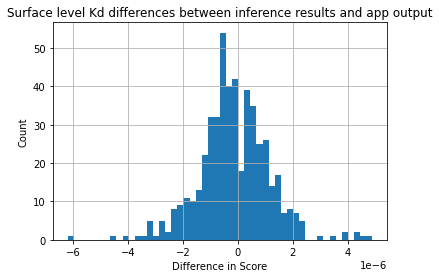

In [14]:
ki_denvis = denvis_surface[(denvis_surface['ligand_id'].isin(ligand_ids)) & (denvis_surface['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Kd"]
ki_webservice = output_df.query('modality == "surface"').sort_values(by=['ligand_id', 'v_num']).reset_index()["Kd"]
(ki_denvis - ki_webservice).hist(bins=50)
plt.title('Surface level Kd differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

##### We can also calculate the ensemble score by averaging over versions, modalities and output types

In [15]:
averaged_df = output_df.groupby(['ligand_id'])[['Kd','Ki']].mean().reset_index(drop=False)
averaged_df['score'] = averaged_df[output_type].sum(axis=1) / len(output_type)

In [16]:
averaged_df

,ligand_id,Kd,Ki,score
0,CHEMBL100382,1.904883,0.692365,1.298624
1,CHEMBL1087462,1.615053,1.424460,1.519757
2,CHEMBL1087727,0.448480,1.279040,0.863760
3,CHEMBL1087820,1.374507,1.638832,1.506669
4,CHEMBL1088247,1.234403,1.427051,1.330727
...,...,...,...,...
95,CHEMBL77279,1.939757,1.800613,1.870185
96,CHEMBL81616,1.657878,1.365310,1.511594
97,CHEMBL85864,0.731613,1.624214,1.177913
98,CHEMBL87981,0.970803,1.689404,1.330103
